<a href="https://colab.research.google.com/github/The1AndOnlyAlex/PyTorch-MNIST/blob/main/pytorch4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from google.colab import files
!pip install idx2numpy

https://www.kaggle.com/datasets/hojjatk/mnist-dataset

In [40]:
uploaded = files.upload()
uploaded2 = files.upload()

Saving train-images.idx3-ubyte to train-images (2).idx3-ubyte


Saving train-labels.idx1-ubyte to train-labels (1).idx1-ubyte


In [41]:
import idx2numpy

filenameImagesTrain = 'train-images.idx3-ubyte'
imagesTrain = idx2numpy.convert_from_file(filenameImagesTrain)
filenameLabelsTrain = 'train-labels.idx1-ubyte'
labelsTrain = idx2numpy.convert_from_file(filenameLabelsTrain)

print(imagesTrain.shape)   # This should show (60000, 28, 28) for MNIST
print(labelsTrain.shape)

(60000, 28, 28)
(60000,)


**Data is ready to be brought in as PyTorch tensor now**

In [42]:
x = torch.from_numpy(imagesTrain.copy()) # copy() so that it is writable. Otherwise will recieve warning
y = torch.from_numpy(labelsTrain.copy())

In [43]:
x.shape

torch.Size([60000, 28, 28])

In [44]:
y.shape

torch.Size([60000])

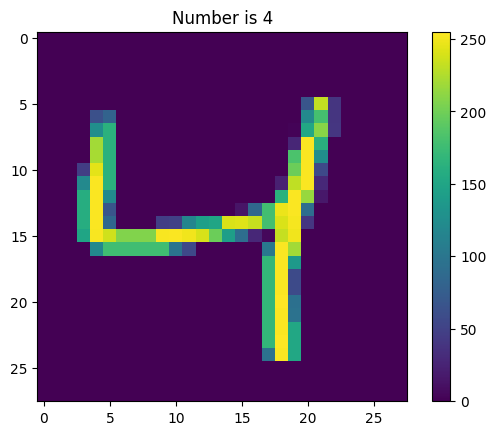

In [45]:
plt.imshow(x[2].numpy())
plt.title(f'Number is {y[2].numpy()}')
plt.colorbar()
plt.show()

# **The One Hot Encoder**

In [46]:
y_original = torch.tensor([2, 4, 3, 0, 1])
y_new = F.one_hot(y_original)

In [47]:
y_original

tensor([2, 4, 3, 0, 1])

In [48]:
y_new

tensor([[0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0]])

Now doing this on the entire dataset:

In [49]:
y_new = F.one_hot(y.long(), num_classes=10)
# PyTorch requires integer index tensors for indexing
# ops—always as torch.int64 which is why y.long() is needed
y_new

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0]])

# **Issues with the Images**

In [50]:
x.shape

torch.Size([60000, 28, 28])

The images are currently 28x28, but we want to turn the images into a vector (which will be length $28^2 = 784). We can do this using the .view property of a tensor. So we are effectively "squishing" all 60000 images of 28x28 into a single vector of length 784.

In [51]:
# -1 here means keep the first dimension of x (60000 images)
x.view(-1,28**2).shape

torch.Size([60000, 784])

# **PyTorch Dataset Object**

In [77]:
class CTDataset(Dataset):
  def __init__(self, imageSet, labelSet):
    self.x = imageSet
    self.y = labelSet
    self.x = self.x / 255.
    self.y = F.one_hot(self.y.long(), num_classes=10).to(float)
  def __len__(self):
    return self.x.shape[0]
  def __getitem__(self, ix):
    return self.x[ix], self.y[ix]

In [53]:
uploaded3 = files.upload()
uploaded4 = files.upload()

Saving t10k-images.idx3-ubyte to t10k-images.idx3-ubyte


Saving t10k-labels.idx1-ubyte to t10k-labels.idx1-ubyte


In [82]:
filenameImagesTest = 't10k-images.idx3-ubyte'
imagesTest = idx2numpy.convert_from_file(filenameImagesTest)
filenameLabelsTest = 't10k-labels.idx1-ubyte'
labelsTest = idx2numpy.convert_from_file(filenameLabelsTest)

imageTrainData = torch.from_numpy(imagesTrain.copy()) # copy() so that it is writable. Otherwise will recieve warning
labelTrainData = torch.from_numpy(labelsTrain.copy()) # copy() so that it is writable. Otherwise will recieve warning
imageTestData = torch.from_numpy(imagesTest.copy()) # copy() so that it is writable. Otherwise will recieve warning
labelTestData = torch.from_numpy(labelsTest.copy()) # copy() so that it is writable. Otherwise will recieve warning


In [84]:
# NOTE: you have to make your CTDataset obejct a little
# differently because you don't have one file for training
# and one file for testing. Instead you have two files (images and labels)
# for both training and testing

# Debugging:
# print(labelTestData.max(), labelTestData.min())
# Or, find all bad labels
# print((labelTestData >= 10).sum())
# print(labelTestData[labelTestData >= 10])

train_ds = CTDataset(imageTrainData, labelTrainData)
test_ds = CTDataset(imageTestData, labelTestData)

In [85]:
len(train_ds)

60000

we can also use slicing:

In [87]:
xs, ys = train_ds[0:4]

In [89]:
ys.shape

torch.Size([4, 10])

# **PyTorch DataLoader Object**

We can then put the Dataset objects inside a DataLoader class. This is useful because we can specify a batch_size. Each iteration through the dataloader will yield a tensor where the first dimension is equal to the batch_size.

In [90]:
train_dl = DataLoader(train_ds, batch_size=5)

In [91]:
for x, y in train_dl:
  print(x.shape)
  print(y.shape)
  break

torch.Size([5, 28, 28])
torch.Size([5, 10])


Since the batch_size here is 5, and there are 60000 images, the length of the DataLoader object should be 12000 batches.

In [92]:
len(train_dl)

12000

# **The Network**

In [93]:
L = nn.CrossEntropyLoss()

In [102]:
class MyNeuralNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.Matrix1 = nn.Linear(28**2,100)
    self.Matrix2 = nn.Linear(100,50)
    self.Matrix3 = nn.Linear(50,10)
    self.R = nn.ReLU()
  def forward(self,x):
    x = x.view(-1,28**2)
    x = self.R(self.Matrix1(x))
    x = self.R(self.Matrix2(x))
    x = self.Matrix3(x)
    return x.squeeze()

In [103]:
f = MyNeuralNet()

Look at network predictions (before optimization):

In [104]:
xs.shape

torch.Size([4, 28, 28])

In [106]:
f(xs)

tensor([[ 0.1093,  0.0189,  0.0324,  0.2228,  0.0692, -0.1441, -0.0915, -0.1321,
         -0.0958,  0.0177],
        [ 0.1087,  0.0461,  0.0257,  0.1959,  0.0941, -0.1600, -0.0703, -0.1381,
         -0.1028, -0.0232],
        [ 0.1399,  0.0700,  0.0348,  0.1538,  0.0594, -0.1296, -0.0731, -0.0839,
         -0.0724, -0.0143],
        [ 0.0957,  0.0447, -0.0032,  0.2031,  0.0491, -0.1708, -0.1089, -0.0687,
         -0.1178, -0.0325]], grad_fn=<SqueezeBackward0>)

This is what they should eventually be equal to:

In [107]:
ys

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)

We can compute the loss between such predictions.

In [108]:
L(f(xs), ys)

tensor(2.2900, dtype=torch.float64, grad_fn=<DivBackward1>)

We want these predictions f(xs) to match the ys for all images. For these to match, the loss function L(f(xs), ys) should be as small as possible. As such, we adjust the weights of f such that L becomes as small as possible. This is done below:

# **Training**

This training loop is copied from the previous notebook, with a few modifications.